# Assignment 3, AE structural optimization
#### Stress constrained mass minimization of trusses
#### Author: Donglai Yang

The truss code uses the implementation in the lecture note

In [59]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import minimize

class Truss:
    def __init__(self, conn, x, bcs, f, E=10.0, rho=0.1):
        self.conn = np.array(conn, dtype=int)
        self.x = np.array(x)
        self.bcs = np.array(bcs, dtype=int)
        self.f = np.array(f)
        self.E = E
        self.rho = rho

        # Extract the number of nodes and elements
        self.nnodes = self.x.shape[0]
        self.nelems = self.conn.shape[0]

        # Form the reduced set of degrees of freedom
        self.reduced = np.setdiff1d(np.arange(2*self.nnodes), self.bcs)

        # Set up the i-j indices for the matrix - these are the row
        # and column indices in the stiffness matrix
        self.elem_vars = np.array((2*self.conn[:,0],
                                   2*self.conn[:,0]+1,
                                   2*self.conn[:,1],
                                   2*self.conn[:,1]+1)).T
        i = []
        j = []
        for index in range(self.nelems):
            for ii in self.elem_vars[index, :]:
                for jj in self.elem_vars[index, :]:
                    i.append(ii)
                    j.append(jj)

        # Convert the lists into numpy arrays
        self.i = np.array(i, dtype=int)
        self.j = np.array(j, dtype=int)

        return

    def compute_mass(self, A):
        """
        Compute the mass of the truss
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)

        mass = self.rho*np.sum(A*Le)

        return mass

    def assemble_stiffness_matrix(self, A):
        """
        Assemble the stiffness matrix
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        scale = self.E*A*Le

        # Compute all of the element matrices
        Ke = np.zeros((self.nelems, 4, 4), dtype=A.dtype)
        for i in range(self.nelems):
            Ke[i,:] = scale[i]*np.outer(B[i,:], B[i,:])

        K = sparse.coo_matrix((Ke.flatten(), (self.i, self.j)))
        K = K.tocsr()

        return K

    def compute_res_adjoint_product(self, y, z=None, alpha=1.0):
        """
        Compute the result:

        product = alpha * y^{T} * d(K(x)*z)/dx

        If z is None then the code uses y = z.
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        scale = self.E*Le

        if z is None:
            y_e = y[self.elem_vars]
            strain_y = np.sum(B*y_e, axis=1)

            product = alpha*scale*strain_y**2
        else:
            y_e = y[self.elem_vars]
            strain_y = np.sum(B*y_e, axis=1)

            z_e = z[self.elem_vars]
            strain_z = np.sum(B*z_e, axis=1)

            product = alpha*scale*strain_y*strain_z

        return product

    def compute_stresses(self, u):
        """
        Compute the stresses in each element
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        ue = np.array((u[2*self.conn[:,0]],
                       u[2*self.conn[:,0]+1],
                       u[2*self.conn[:,1]],
                       u[2*self.conn[:,1]+1]), dtype=u.dtype).T

        stress = self.E*np.sum(B*ue, axis=1)
        return stress

    def compute_stress_derivative(self, dfds):
        """
        Compute the stresses in each element
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        dfdu = np.zeros(2*self.nnodes, dtype=dfds.dtype)
        np.add.at(dfdu, 2*self.conn[:, 0], self.E*dfds*B[:, 0])
        np.add.at(dfdu, 2*self.conn[:, 0]+1, self.E*dfds*B[:, 1])
        np.add.at(dfdu, 2*self.conn[:, 1], self.E*dfds*B[:, 2])
        np.add.at(dfdu, 2*self.conn[:, 1]+1, self.E*dfds*B[:, 3])

        return dfdu

    def reduce_vector(self, forces):
        """
        Eliminate essential boundary conditions from the vector
        """
        return forces[self.reduced]

    def reduce_matrix(self, matrix):
        """
        Eliminate essential boundary conditions from the matrix
        """
        temp = matrix[self.reduced, :]
        return temp[:, self.reduced]

    def solve(self, A, f=None):
        """
        Perform a linear static analysis
        """

        K = self.assemble_stiffness_matrix(A)
        Kr = self.reduce_matrix(K)
        if f is None:
            f = self.f
        fr = self.reduce_vector(f)

        ur = sparse.linalg.spsolve(Kr, fr)

        u = np.zeros(2*self.nnodes, dtype=ur.dtype)
        u[self.reduced] = ur

        return u

    def compute_KS(self, A, rho_ks=10.0):
        """
        Compute the KS function from the design variables
        """
        u = self.solve(A)
        s = self.compute_stresses(u)
        c = np.max(s)
        return c + np.log(np.sum(np.exp(rho_ks*(s - c))))/rho_ks

    def compute_KS_gradient(self, A, rho_ks=10.0):
        """
        Compute the gradient of the KS function with respect to the design variables A
        using the adjoint method.
        """
        # Compute the stress in the truss
        u = self.solve(A)
        s = self.compute_stresses(u)
        ksvalue = c_ks(s)
        # Compute the derivative of the KS function wrt state variable (displacement)
        dfds = self.dc_ks(s, rho_ks=rho_ks)
        dfdu = self.compute_stress_derivative(dfds)

        # Solve for the adjoint variables
        psi = -self.solve(A, f=dfdu)

        # Compute the total derivative
        dfdx = self.compute_res_adjoint_product(psi, u)

        return dfdx

    def dc_ks(self, s, rho_ks=10.0):
        """
        Compute the derivative of the KS function
        """
        c = np.max(s)
        eta = np.exp(rho_ks*(s - c))
        eta /= np.sum(eta)
        return eta


    def plot(self, u=None, scale=1.0, **kwargs):
        """
        Visualize the truss and optionally its deformation.
        """
        fig, ax = plt.subplots(1, 1, facecolor='w', **kwargs)

        if u is not None:
            x = self.x + scale*u.reshape((-1, 2))
        else:
            x = self.x

        for index in range(self.nelems):
            i = self.conn[index, 0]
            j = self.conn[index, 1]
            plt.plot([x[i,0], x[j,0]], [x[i,1], x[j,1]], '-ko')

        ax.axis('equal')

        return

    def plot_areas(self, A, **kwargs):
        """
        Plot the bar areas
        """
        fig, ax = plt.subplots(1, 1, facecolor='w', **kwargs)

        stress = self.compute_stresses(self.solve(A))

        cm = plt.get_cmap('coolwarm')
        cNorm = colors.Normalize(vmin=min(stress), vmax=max(stress))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

        for index, bar in enumerate(conn):
            n1 = bar[0]
            n2 = bar[1]
            if A[index] >= 1e-4*max(A):
                plt.plot([self.x[n1, 0], self.x[n2, 0]],
                         [self.x[n1, 1], self.x[n2, 1]],
                         color=scalarMap.to_rgba(stress[index]),
                         linewidth=5*(A[index]/max(A)))

        ax.axis('equal')

        return

def c_ks(s, rho_ks=10.0):
    """
    Compute the KS function
    """
    c = np.max(s)
    return c + np.log(np.sum(np.exp(rho_ks*(s - c))))/rho_ks


#### Part 1: Implement the KS function for the stress constraints. Plot the error C_{KS}(s, rho) - max si vs 1/rho for a range of rho values. What conclusions can you draw from this plot?

Answer: from the plot below, we see that as rho becomes larger (1/rho becomes smaller), the difference between the maximum of the stress and KS function becomes increasing smaller, and thus the approximation becomes more robust. I also notice that such a relationship follows a linear relationship in the log-log space, thus suggesting it follows a power law relationship which is helpful for intuition.

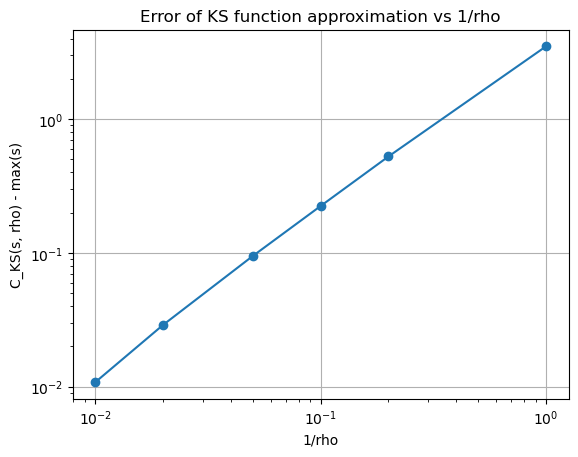

In [8]:
# generate random s values
s = np.random.uniform(size=50)
rho_values = np.array([1.0, 5.0, 10.0, 20.0, 50.0, 100.0])

cks_values = []
errors = []
for rho in rho_values:
    cks = c_ks(s, rho_ks=rho)
    cks_values.append(cks)
    errors.append(cks - np.max(s))

# plot error vs 1/rho
plt.figure()
plt.loglog(1.0/rho_values, errors, 'o-')
plt.xlabel('1/rho')
plt.ylabel('C_KS(s, rho) - max(s)')
plt.title('Error of KS function approximation vs 1/rho')
plt.grid()
plt.show()

#### Part 2: Find the minimum mass truss using a fully stressed design procedure. Plot mass vs iteration. What is the minimum stress? How many iterations does it take before the design converges?

Anwers: 

According to the definition, a fully stressed design computes the minimum size (here is area size) satisfying the stress constraint, and repeat until size converges. From our experiment, I see that assuming a convergence criterion such that the change in area between iteration is less than 1e-6, it takes only 6 iterations to converge. The minimum mass is 211.03 kg. The plot of mass vs iteration is show below.

Iteration 1, change in area: 0.503938
Iteration 2, change in area: 0.000322
Iteration 3, change in area: 0.000060
Iteration 4, change in area: 0.000013
Iteration 5, change in area: 0.000003
Iteration 6, change in area: 0.000001


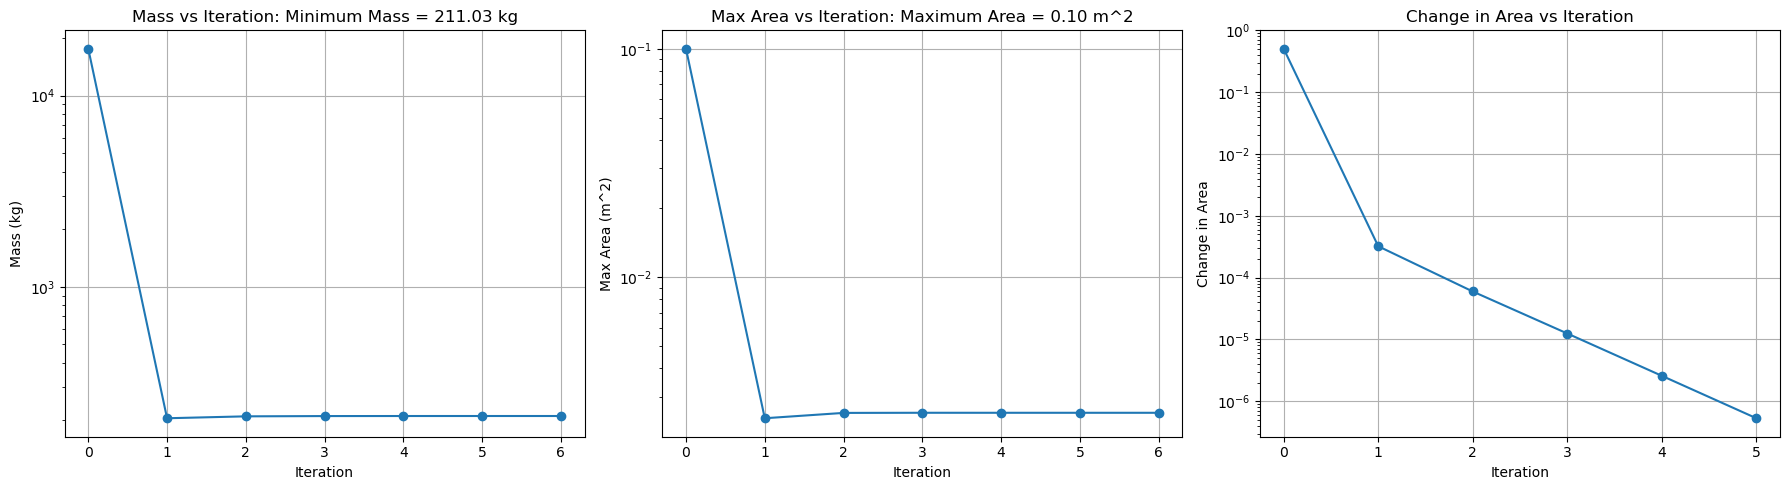

In [35]:
E = 70e9 # Pa, Young's modulus
sigma_max = 300e6 # max stress in Pa
rho = 2700 # kg/m^3, density
Amin = 1e-3 # minimum area in m^2
L = 2.5 # m, length
P = 250e3 # N, load

xpos = [[0,0],[0,L],[L,L],[L,0],[2*L,0],[2*L,L],[3*L,L],[3*L,0], [4*L,0],[4*L,L],[5*L,L],[5*L,0]]
conn = [[0,1],[1,2],[1,3],[0,2],[0,3],[2,3],[2,5],[2,4],[3,5],[3,4],[4,5],[5,6],[5,7],[4,6],[4,7],[7,6],[6,9],[6,8],[7,9],[7,8],[8,9],[9,10],[9,11],[8,10],[8,11],[10,11]]
bcs = [0,1,22,23]
force = [0,0,0,0,
         0,0,0,-P,
         0,-P,0,0,
         0,0,0,-P,
         0,-P,0,0,
         0,0,0,0]


prob = Truss(conn, xpos, bcs, force, E=E, rho=rho)

# set up iteration for "fully stressed design"
convergence_criterion = 1e-6 # change in area between iterations
max_iter = 50
A = np.ones(prob.nelems)*0.1 # initial area
Amin_vec = np.ones(prob.nelems)*Amin
A_history = [A.copy()]
mass_history = [np.sum(A*L*rho)]
change_history = []

converge_flag = False
while not converge_flag:
    A_old = A.copy()

    # compute the stress and force
    sigma = prob.compute_stresses(prob.solve(A_old))
    F = sigma * A_old

    # compute the minimum size satisfying the stress constraint
    sizes = np.vstack((np.abs(F)/sigma_max, Amin_vec))
    A = np.max(sizes, axis=0)
    # record history
    A_history.append(A.copy())
    mass_history.append(np.sum(A*L*rho))

    # check convergence
    change = np.linalg.norm(A - A_old, ord=2)
    change_history.append(change)
    print(f'Iteration {len(A_history)-1}, change in area: {change:.6f}')

    if change < convergence_criterion or len(A_history)-1 >= max_iter:
        converge_flag = True

# plot subplots: mass vs iteration, and max area vs iteration
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.semilogy(mass_history, 'o-')
plt.xlabel('Iteration')
plt.ylabel('Mass (kg)')
plt.title('Mass vs Iteration: Minimum Mass = {:.2f} kg'.format(mass_history[-1]))
plt.grid()

plt.subplot(1,3,2)
plt.semilogy([np.max(A) for A in A_history], 'o-')
plt.xlabel('Iteration')
plt.ylabel('Max Area (m^2)')
plt.title('Max Area vs Iteration: Maximum Area = {:.2f} m^2'.format(np.max([np.max(A) for A in A_history])))
plt.grid()

plt.subplot(1,3,3)
plt.semilogy(change_history, 'o-')
plt.xlabel('Iteration')
plt.ylabel('Change in Area')
plt.title('Change in Area vs Iteration')
plt.grid()

plt.tight_layout()
plt.show()

#### Part 3: Implement an adjoint-based method to compute the derivative of the KS function with respect to the design variables. Compare the accuracy of your adjoint implementation against forward differencing and the complex step for a range of step sizes. What conclusions can you draw from this comparison?

Answer:

We make use of the lecture notes functions to compute the adjoint and the gradient. First we compute $\frac{\partial \text{KS}}{\partial s}$ which is straight forward, using the analytical derivation. Then we make use of the computed $\frac{\partial \text{KS}}{\partial s}$ to get $\frac{\partial \text{KS}}{\partial u}$, making use of the definition of s, constitutive relation, and the coordinate transformation at each element. Then we solve for the adjoint variable / Lagrange multiplier $\psi$, by solving $K \psi = -\left(\frac{\partial \text{KS}}{\partial u}\right)^T$. Finally, to compute the gradient of $\text{KS}$ with respect to the area. The KS function does not depend explicitly on x, and thus we only need to evaluate $\left[\psi^T \frac{\partial K(x) u}{\partial x}  \right]_i$ at the elemental level $e_i$

Regarding the accuracy of real-valued finite difference and complex step, when compared to the adjoint, we see that the adjoint-based gradient is very similar to complex step method in their results, whereas the forward difference has considerably higher errors. Therefore it's obvious that: adjoint-based derivative is analytical and has on-par performance with the complex step method, and should be generally adopted in practice as opposed to the real-valued forward difference.

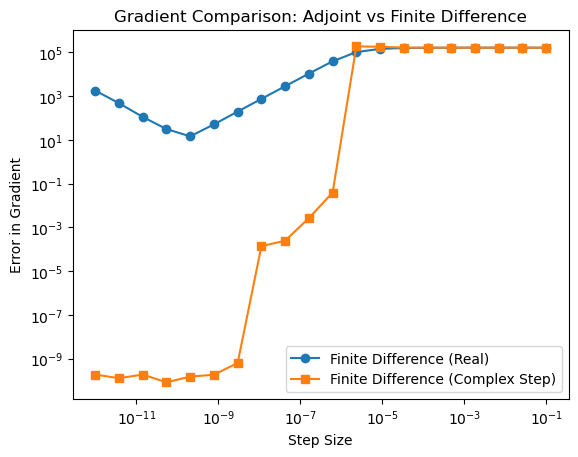

In [56]:
def dc_ks(s, rho_ks=10.0):
    """
    Compute the derivative of the KS function
    """
    c = np.max(s)
    eta = np.exp(rho_ks*(s - c))
    eta /= np.sum(eta)
    return eta

def compute_si(sigma):
    """
    Compute the stress ratio si = sigma_i / sigma_max
    """
    sigma_max = np.max(sigma)
    return sigma / sigma_max

def finite_difference_real_grad(x_vec, func, h=1e-8):
    # compute the finite difference gradient for a function at x_vec
    # where x_vec can be any length
    dfdx = np.zeros(len(x_vec))
    for i in range(len(x_vec)):
        x_plus_h = np.array(x_vec, dtype=float)
        x_plus_h[i] += h
        f_plus_h = func(x_plus_h)
        f0 = func(x_vec)
        dfdx[i] = (f_plus_h - f0)/h
    return dfdx
            
def finite_difference_complex_grad(x_vec, func, h=1e-8):  # larger h
    dfdx = np.zeros(len(x_vec))
    for i in range(len(x_vec)):
        x_plus_ih = np.array(x_vec, dtype=complex)
        x_plus_ih[i] += 1j*h
        f_plus_ih = func(x_plus_ih)
        dfdx[i] = np.imag(f_plus_ih)/h
    return dfdx

# Set the initial bar areas
x0 = np.ones(prob.nelems)

# Compute the stress in the truss
u = prob.solve(x0)
s = prob.compute_stresses(u)
ksvalue = c_ks(s)
# Compute the derivative of the KS function wrt state variable (displacement)
dfds = dc_ks(s)
dfdu = prob.compute_stress_derivative(dfds)

# Solve for the adjoint variables
psi = -prob.solve(x0, f=dfdu)

# Compute the total derivative
dfdx = prob.compute_res_adjoint_product(psi, u)

# compare to forwad differencing and complex step
step_sizes = np.logspace(-12, -1, num=20)
fd_real_errors = []
fd_complex_errors = []
for h in step_sizes:
    fd_real_grad = finite_difference_real_grad(x0, lambda x: c_ks(prob.compute_stresses(prob.solve(x))), h=h)
    fd_complex_grad = finite_difference_complex_grad(x0, lambda x: c_ks(prob.compute_stresses(prob.solve(x))), h=h)
    # append
    fd_real_errors.append(np.linalg.norm(fd_real_grad - dfdx))
    fd_complex_errors.append(np.linalg.norm(fd_complex_grad - dfdx))

# plot the errors
plt.figure()
plt.loglog(step_sizes, fd_real_errors, 'o-', label='Finite Difference (Real)')
plt.loglog(step_sizes, fd_complex_errors, 's-', label='Finite Difference (Complex Step)')
plt.xlabel('Step Size')
plt.ylabel('Error in Gradient')
plt.title('Gradient Comparison: Adjoint vs Finite Difference')
plt.legend()


#### Part 4: use the derivative implementation of the KS function from Question 3 to compute the minimum mass structure subject to stress constraints. What is the minimum mass truss?

Answer:

I added the d(KS)/dx code from part 3 to the class object at the beginning. The optimization takes 27 iterations to converge, and the structure with area color-coded is plotted below. The minimum mass is 203494.6 kg. 

In [73]:
# Compute the gradient of the mass of the truss
xd = prob.x[prob.conn[:,1],0] - prob.x[prob.conn[:,0],0]
yd = prob.x[prob.conn[:,1],1] - prob.x[prob.conn[:,0],1]
Le = np.sqrt(xd**2 + yd**2)
m0 = rho*Le

options = {
    'maxiter': 100,  # Limit to 100 iterations
    'disp': True    # Display convergence messages
}

# no scaling
prob = Truss(conn, xpos, bcs, force, E=E, rho=rho)
res = minimize(prob.compute_mass, x0, 
               jac=lambda x: -np.array(m0),
               method='SLSQP',
               bounds=[(1e-12, 10.0)]*len(x0),
               constraints=[{'type': 'ineq',
                             'fun': lambda x: (sigma_max - prob.compute_KS(x)),
                             'jac': lambda x: prob.compute_KS_gradient(x)}],
                             options=options)

# Show the bar areas
print(res)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 203494.61570963718
            Iterations: 27
            Function evaluations: 243
            Gradient evaluations: 23
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 203494.61570963718
       x: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
     nit: 27
     jac: [-6.750e+03 -6.750e+03 ... -6.750e+03 -6.750e+03]
    nfev: 243
    njev: 23


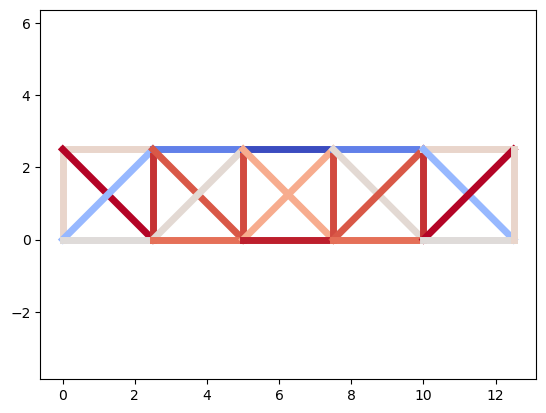

In [ ]:
prob.plot_areas(res.x)
plt.show()
